*THIS FILE IS USED TO PERFORM EXPERIMENTS ON THE RUSSIA BN*

In [3]:
# Imports
import numpy as np
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from BNReasoner import BNReasoner
import test_BNR






In [4]:

# Perform Unit Tests
test_BNR.test()

In [5]:
#LOAD BN 
BN = BNReasoner('testing/Russia.BIFXML')

# Query P(RussiaAttackNato, RussiaStartingANuclearWar|InternationalSupportForUkraine = True, RussiaInfiltratingUkraine = True)
Q = ['RussiaAttackNato', 'RussiaStartingANuclearWar']
e = {'InternationalSupportForUkraine': True, 'RussiaInfiltratingUkraine': True}
BN.marginalDistribution(Q, e)




,RussiaInfiltratingUkraine,InternationalSupportForUkraine,RussiaAttackNato,RussiaStartingANuclearWar,p
0,True,True,False,False,0.540484
1,True,True,False,True,0.179616
2,True,True,True,False,0.178417
3,True,True,True,True,0.101483


In [21]:
# Testing procedure

# Loop over test data
num_samples = 1000
time_per_case = np.zeros((num_samples, 5))
BN = BNReasoner('testing/Russia.BIFXML')

for i in range(0, num_samples):
    variables = BN.bn.get_all_variables()
    # sample Q
    Q = np.random.choice(variables, size=np.random.randint(1, 3)).tolist()
    # drop Q from variables
    variables = [x for x in variables if x not in Q]
    # sample e
    random_size = np.random.randint(1, len(variables))
    e = dict(zip(np.random.choice(variables, size=random_size), np.random.choice([True, False], size=random_size)))

    try:
        begin = time.time()
        # Test marginalDistribution
        ### Case 1: no edge pruning
        BN_1 = copy.deepcopy(BN)
        BN_1.prune_edge = False
        BN_1.marginalDistribution(Q, e)
        time_1 = time.time() 
        time_per_case[i,0] = time_1 - begin


        ### Case 2: no node pruning
        BN_2 = copy.deepcopy(BN)
        BN_2.prune_node = False
        BN_2.marginalDistribution(Q, e)
        time_2 = time.time()  
        time_per_case[i,1] = time_2 - time_1

        ### Case 3: no edge pruning, no node pruning
        BN_3 = copy.deepcopy(BN)
        BN_3.prune_node = False
        BN_3.prune_node = False
        BN_3.marginalDistribution(Q, e)
        time_3 = time.time()
        time_per_case[i,2] = time_3 - time_2

        ### Case 4: edge pruning, node pruning 
        BN_4 = copy.deepcopy(BN)
        BN_4.marginalDistribution(Q, e, order_method= 'min_degree')
        time_4 = time.time() 
        time_per_case[i,3] = time_4 - time_3

        ### Case 5: min_fill
        BN_5 = copy.deepcopy(BN)
        BN_5.marginalDistribution(Q, e, order_method='min_fill')
        time_5 = time.time() 
        time_per_case[i,4] = time_5 - time_4
    except:
        print('Error in marginalDistribution with Q = {} and e = {}'.format(Q, e))
        break




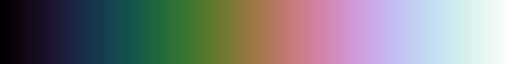

In [22]:
df1 = pd.DataFrame(time_per_case[:,:-1], columns=['no edge pruning', 'no node pruning', 'none', 'both'])
df2 = pd.DataFrame(time_per_case[:,-2:], columns=['min_degree', 'min_fill'])
sns.color_palette("cubehelix", as_cmap=True)

     no edge pruning  no node pruning      none      both
0           0.034875         0.033343  0.030394  0.031000
1           0.014876         0.022146  0.023117  0.013860
2           0.027478         0.025490  0.024011  0.022138
3           0.026826         0.027850  0.027949  0.029722
4           0.033286         0.027442  0.025913  0.024595
..               ...              ...       ...       ...
995         0.025382         0.025030  0.025859  0.026208
996         0.025774         0.026107  0.025444  0.025578
997         0.024423         0.024277  0.023345  0.023694
998         0.023086         0.022725  0.022615  0.023797
999         0.025703         0.025376  0.024443  0.025306

[1000 rows x 4 columns]


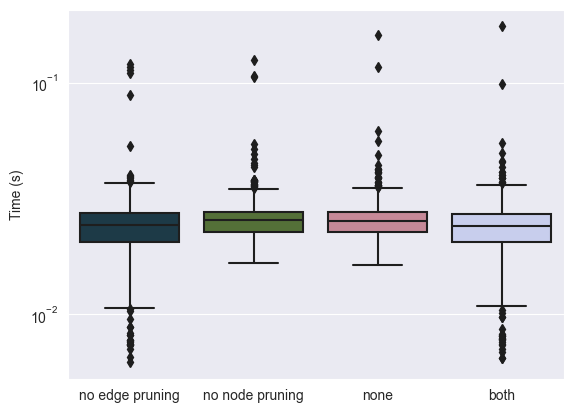

In [32]:
print(df1)
sns.boxplot(df1, palette = "cubehelix")
plt.ylabel('Time (s)')
plt.yscale('log')
plt.savefig('time_per_case.png')


     min_degree  min_fill
0      0.031000  0.030047
1      0.013860  0.014850
2      0.022138  0.023998
3      0.029722  0.031545
4      0.024595  0.024178
..          ...       ...
995    0.026208  0.025189
996    0.025578  0.025760
997    0.023694  0.024196
998    0.023797  0.023065
999    0.025306  0.025479

[1000 rows x 2 columns]


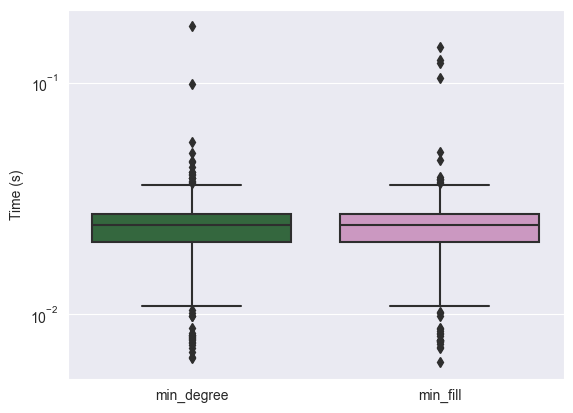

In [31]:
print(df2)
sns.boxplot(df2,  palette = "cubehelix")
plt.yscale('log')
plt.ylabel('Time (s)')
plt.savefig('fil_heur.png')

In [35]:
### unequal independent one-sided t-test
from scipy.stats import ttest_ind
pval_matrix = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        pval_matrix[i,j] = ttest_ind(df1.iloc[:,i], df1.iloc[:,j], alternative= 'greater', equal_var=False)[1]

print(pval_matrix)
df_res = pd.DataFrame(pval_matrix, columns=['no edge pruning', 'no node pruning', 'none', 'both'], index=['no edge pruning', 'no node pruning', 'none', 'both'])
s = df_res.style.format(precision = 3)
latex_tab = s.to_latex(hrules = True, position_float = "centering",  caption = f'Pruning Variations Two-Sided Independent T-Test (M = 1000)',
                            label=f'tab: pruning_pval', position = 'h!')
print(latex_tab)

[[5.00000000e-01 9.99999059e-01 9.99996421e-01 1.87011605e-01]
 [9.40713359e-07 5.00000000e-01 4.22074130e-01 1.62323377e-09]
 [3.57902983e-06 5.77925870e-01 5.00000000e-01 1.05647877e-08]
 [8.12988395e-01 9.99999998e-01 9.99999989e-01 5.00000000e-01]]
\begin{table}[h!]
\centering
\caption{Pruning Variations Two-Sided Independent T-Test (M = 1000)}
\label{tab: pruning_pval}
\begin{tabular}{lrrrr}
\toprule
 & no edge pruning & no node pruning & none & both \\
\midrule
no edge pruning & 0.500 & 1.000 & 1.000 & 0.187 \\
no node pruning & 0.000 & 0.500 & 0.422 & 0.000 \\
none & 0.000 & 0.578 & 0.500 & 0.000 \\
both & 0.813 & 1.000 & 1.000 & 0.500 \\
\bottomrule
\end{tabular}
\end{table}



In [37]:
### unequal independent one-sided t-test
from scipy.stats import ttest_ind
pval_matrix = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        pval_matrix[i,j] = ttest_ind(df2.iloc[:,i], df1.iloc[:,j], alternative= 'greater', equal_var=False)[1]

print(pval_matrix)
df_res = pd.DataFrame(pval_matrix, columns=['min degree', 'min_fill'], index=['min degree', 'min_fill'])
s = df_res.style.format(precision = 3)
latex_tab = s.to_latex(hrules = True, position_float = "centering",  caption = f'Ordering Heuristic Variations Two-Sided Independent T-Test (M = 1000)',
                            label=f'tab: pruning_pval', position = 'h!')
print(latex_tab)

[[0.8129884  1.        ]
 [0.64105654 0.99999984]]
\begin{table}[h!]
\centering
\caption{Ordering Heuristic Variations Two-Sided Independent T-Test (M = 1000)}
\label{tab: pruning_pval}
\begin{tabular}{lrr}
\toprule
 & min degree & min_fill \\
\midrule
min degree & 0.813 & 1.000 \\
min_fill & 0.641 & 1.000 \\
\bottomrule
\end{tabular}
\end{table}

